In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download Inception v3 weights to local machine
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import Inception v3 Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)

# Load Inception v3 weights into model
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model.load_weights(local_weights_file)

--2023-02-09 11:14:04--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.128, 108.177.111.128, 142.250.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   182MB/s    in 0.5s    

2023-02-09 11:14:04 (182 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
for layer in pre_trained_model.layers:
    layer.trainable = False

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

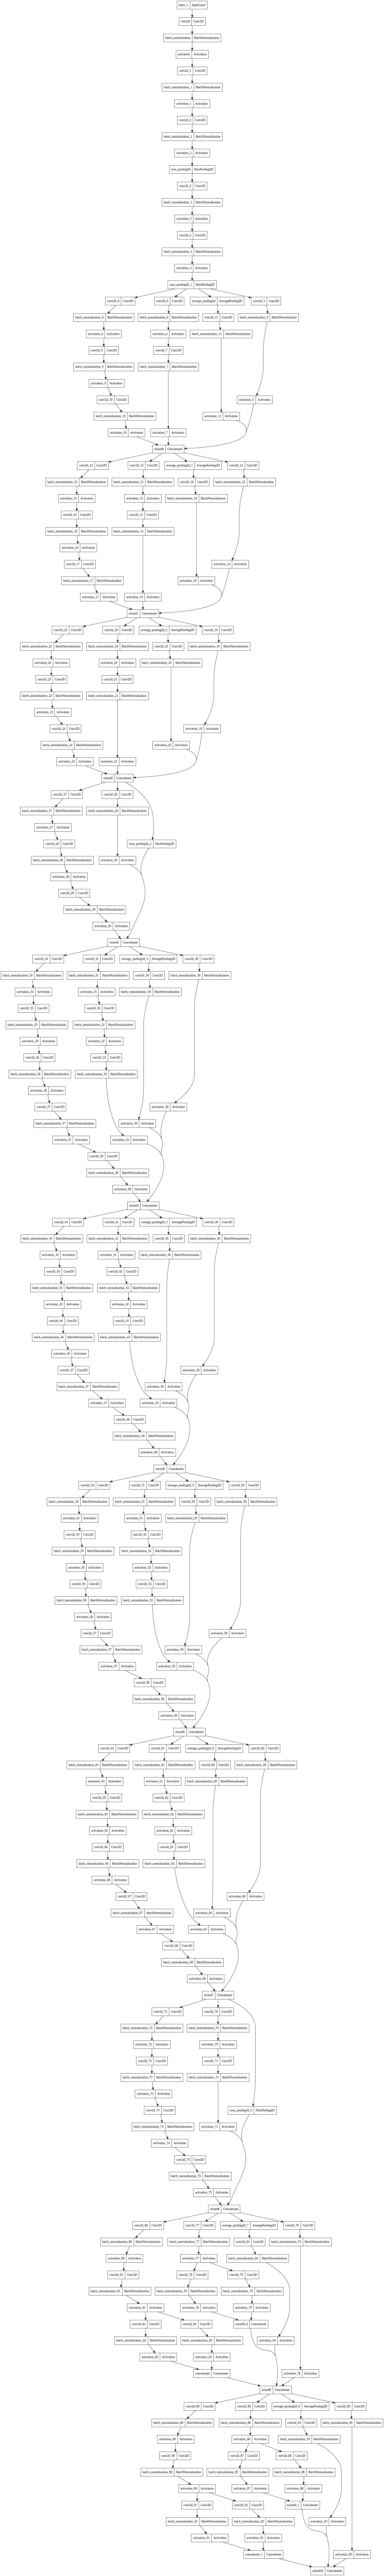

In [5]:
pre_trained_model.summary()
plot_model(pre_trained_model, to_file='inception_v3_model.png', show_shapes=False, show_layer_names=True)

In [6]:
last_layer = pre_trained_model.get_layer('mixed8')
last_output = last_layer.output

In [7]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(14, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

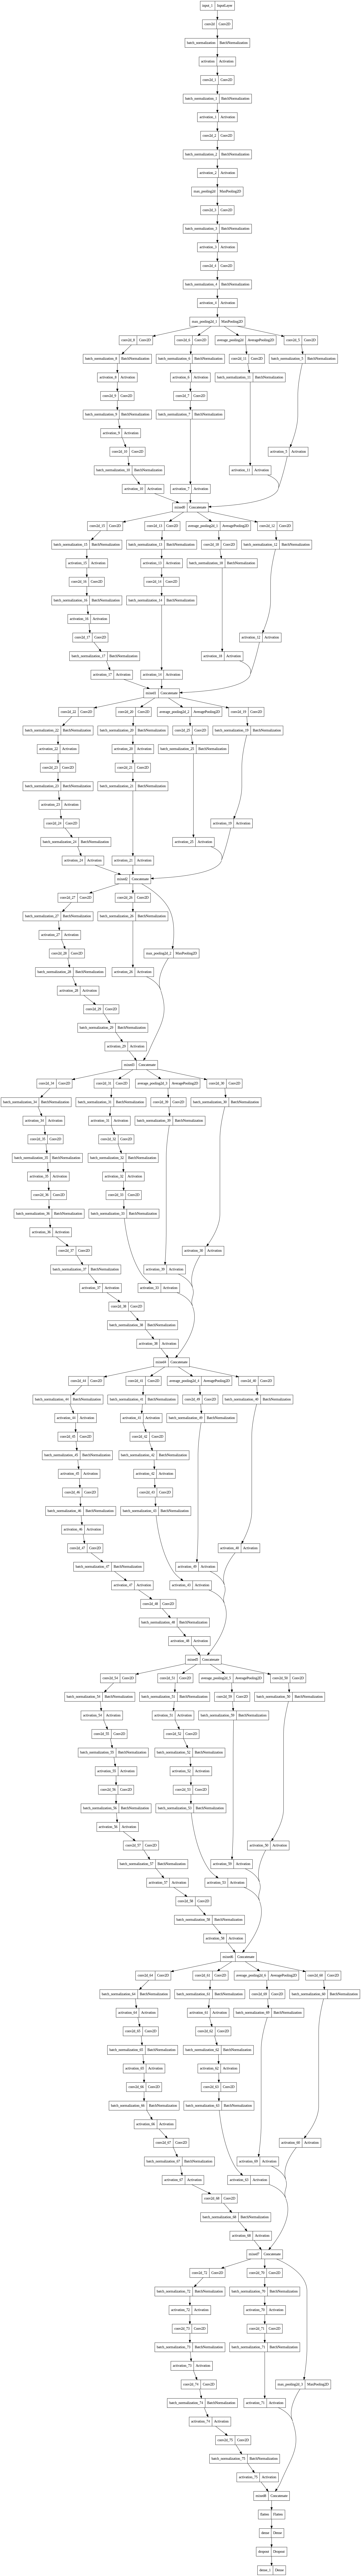

In [8]:
model.summary()
plot_model(model, to_file='inception_v3_with_dense_layers_model.png', show_shapes=False, show_layer_names=True)

In [9]:
train_dir = '/content/drive/MyDrive/trainF/train'
validation_dir = '/content/drive/MyDrive/validateF'
test_dir = '/content/drive/MyDrive/trainF/test'

#train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,  height_shift_range=0.2, zoom_range=0.2,  shear_range=0.2, horizontal_flip=True, fill_mode='nearest')  # with data augmentation for train set

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)  # no augmentation for validation set
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))


validation_generator = valid_datagen.flow_from_directory(validation_dir,
                                                         batch_size=100,
                                                         class_mode='categorical',
                                                         target_size=(150, 150))

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 505 images belonging to 14 classes.
Found 164 images belonging to 14 classes.
Found 134 images belonging to 14 classes.


In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      acc = logs.get('accuracy')
      val_acc = logs.get('val_accuracy')
      if acc is not None and val_acc is not None and acc > 0.99 and val_acc > 0.99:
            print("\nCancelling training as model has reached 99% accuracy and 99% validation accuracy!")
            self.model.stop_training = True

In [11]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

Prvo treniranje

---


steps_per_epoch=10,
                              epochs=10,
                              validation_steps=10,
                              verbose=2

In [12]:
callbacks = myCallback()
history = model.fit_generator(generator=train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=5,
                              epochs=6,
                              validation_steps=1,
                              verbose=2,
                              callbacks=[callbacks])

Epoch 1/6
5/5 - 35s - loss: 2.2938 - accuracy: 0.3407 - val_loss: 1.3130 - val_accuracy: 0.7000 - 35s/epoch - 7s/step
Epoch 2/6
5/5 - 28s - loss: 0.8070 - accuracy: 0.7877 - val_loss: 0.4162 - val_accuracy: 0.9300 - 28s/epoch - 6s/step
Epoch 3/6
5/5 - 28s - loss: 0.4381 - accuracy: 0.8568 - val_loss: 0.2451 - val_accuracy: 0.9900 - 28s/epoch - 6s/step
Epoch 4/6

Cancelling training as model has reached 99% accuracy and 99% validation accuracy!
5/5 - 26s - loss: 0.1264 - accuracy: 0.9951 - val_loss: 0.1525 - val_accuracy: 0.9900 - 26s/epoch - 5s/step


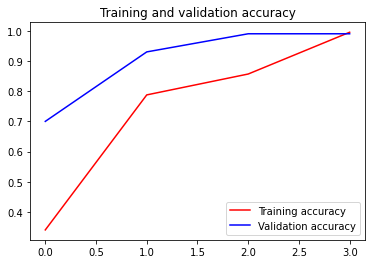

<Figure size 432x288 with 0 Axes>

In [13]:
plot_result(history)

In [14]:
model.save("ModelV3.h5")

Text(0.5, 1.0, 'Grafik')

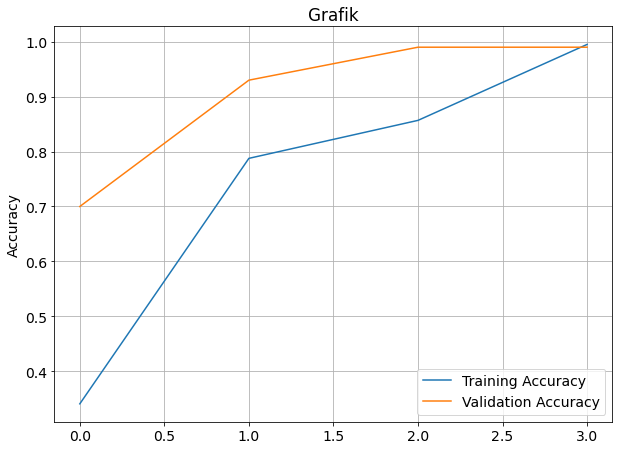

In [15]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
  
  
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'Grafik')

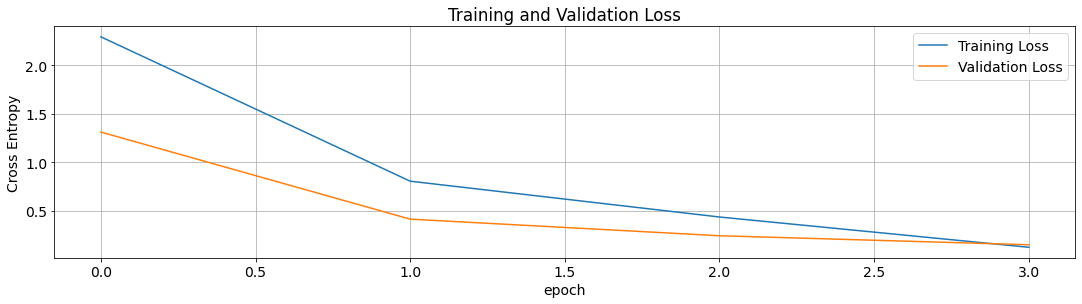

In [16]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [17]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 
  
print("Loss: ",accuracy_score[0])

2/2 [==============================] - 7s 3s/step - loss: 0.1535 - accuracy: 0.9939
[0.15350967645645142, 0.9939024448394775]
Accuracy: 99.3902%
Loss:  0.15350967645645142


In [18]:
import cv2

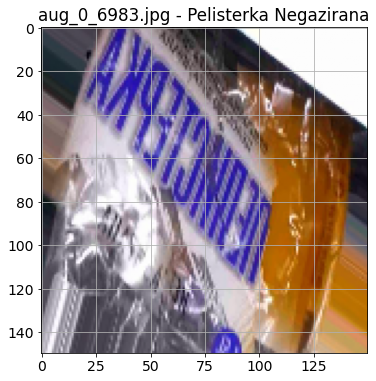

In [19]:
img_path =  '/content/drive/MyDrive/validateF/PelisterkaNegazirana/aug_0_6514.jpg'
img = cv2.imread(img_path)
resized_img = cv2.resize(img, (150, 150)).reshape(-1, 150, 150, 3)/255
  
plt.figure(figsize=(6,6))
plt.title("aug_0_6983.jpg - Pelisterka Negazirana")
plt.imshow(resized_img[0])

In [20]:
predictions = model.predict(validation_generator)
print(predictions[5])

2/2 [==============================] - 9s 2s/step
[3.2122788e-04 1.7199281e-03 1.1763746e-04 9.8710436e-01 2.2111215e-04
 3.2342854e-04 3.6072958e-04 2.4915775e-04 4.5547467e-03 1.5132329e-03
 1.1510417e-03 9.1796182e-04 9.1575792e-05 1.3539266e-03]


In [21]:
import numpy as np

In [22]:
classes = np.argmax(predictions, axis = 1)
print(classes)

[ 6  1  2  2 10  3  9  9 10  1  1  9  0 13  4 11  2  7  9 12  7  3  5  1
 12  6 12  7  8  8 13  9  1  7  2  1  6 10  3  2 11 12  6  8  1  2  1  6
  1  4  4 12 11  2  2  6  6  5  8  9 11  5  3  0 11  3  8  1 13  3  4 13
  8  1  4  3  2  5  9  4  5  9  4  4 11  4  5  7  3  9 13  0  8  8 11 12
 12  9  4 10  4 11 11 12  9  7 13  9  1  1  3  0  5 13 10  6  8  1 11  0
  9  2 12 10  3  3  3  2  7 13  3 11  6  3  0  2 10 13  5 13 13 10  1  7
  9  2 12 11  6 11  4  7  5  8  0  1  3  3  5  9  5  5  1  7]


In [23]:
# evaluate this model on the test data ACC:
test_loss, test_acc = model.evaluate_generator(test_generator)
print('test acc:', test_acc)

test acc: 1.0
